In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].dtype)

datetime64[ns]


Setting the 'Date' column as the index in the DataFrame

In [ ]:
df.set_index('Date', inplace=True)

Loading the data from the given CSV link, checking for any missing values, extracted and normalized the temporal features

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url)
print(df.isnull().sum())
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Day', 'Month', 'Year', 'Temp']])
df[['Day', 'Month', 'Year', 'Temp']] = scaled_data


Date    0
Temp    0
dtype: int64


Splitting data into train and test sets  , train data 70% and test data 30%

In [ ]:
train_size = int(len(df) * 0.7)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]




#setting  the sequences to reshape data for RNN model

In [ ]:
def create_sequences(data, time_steps):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        seq_data = data.iloc[i : i + time_steps][['Day', 'Month', 'Year', 'Temp']]
        label = data.iloc[i + time_steps]['Temp']
        sequences.append(seq_data.values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

time_steps = 7
train_seq, train_label = create_sequences(train_data, time_steps)
test_seq, test_label = create_sequences(test_data, time_steps)

if len(train_seq) != len(train_label):
    train_seq = train_seq[:len(train_label)]
if len(test_seq) != len(test_label):
    test_seq = test_seq[:len(test_label)]

train_seq_3d = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], train_seq.shape[2]))
test_seq_3d = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], test_seq.shape[2]))


#Here we have build sequential model, With Adam as optimizer function. and loss function MSE

In [ ]:
from tensorflow.keras.layers import LSTM

train_seq_3d = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], train_seq.shape[2]))

rnn_model = Sequential()
rnn_model.add(LSTM(50, return_sequences=True, input_shape=(train_seq_3d.shape[1], train_seq_3d.shape[2])))
rnn_model.add(LSTM(50, return_sequences=True))
rnn_model.add(LSTM(50))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:

rnn_model.fit(train_seq_3d, train_label, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
80/80 [==============================] - 1s 16ms/step - loss: 0.0111
Epoch 2/10
80/80 [==============================] - 2s 23ms/step - loss: 0.0107
Epoch 3/10
80/80 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 4/10
80/80 [==============================] - 1s 17ms/step - loss: 0.0096
Epoch 5/10
80/80 [==============================] - 2s 23ms/step - loss: 0.0096
Epoch 6/10
80/80 [==============================] - 2s 23ms/step - loss: 0.0092
Epoch 7/10
80/80 [==============================] - 2s 22ms/step - loss: 0.0091
Epoch 8/10
80/80 [==============================] - 1s 15ms/step - loss: 0.0091
Epoch 9/10
80/80 [==============================] - 1s 15ms/step - loss: 0.0090
Epoch 10/10
80/80 [==============================] - 1s 16ms/step - loss: 0.0090


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

train_seq_flat = train_seq.reshape((train_seq.shape[0], train_seq.shape[1] * train_seq.shape[2]))
test_seq_flat = test_seq.reshape((test_seq.shape[0], test_seq.shape[1] * test_seq.shape[2]))
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(train_seq_flat.shape[1],)))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(1))

mlp_model.compile(optimizer='adam', loss='mean_squared_error')
mlp_model.fit(train_seq_flat, train_label, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
80/80 [==============================] - 1s 3ms/step - loss: 0.0419
Epoch 2/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0113
Epoch 3/10
80/80 [==============================] - 1s 10ms/step - loss: 0.0105
Epoch 4/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0101
Epoch 5/10
80/80 [==============================] - 1s 8ms/step - loss: 0.0099
Epoch 6/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 7/10
80/80 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 8/10
80/80 [==============================] - 1s 10ms/step - loss: 0.0092
Epoch 9/10
80/80 [==============================] - 1s 8ms/step - loss: 0.0092
Epoch 10/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0091


Calculate MAE and RMSE for MLP model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mlp_predictions = mlp_model.predict(test_seq_flat)
mlp_mae = mean_absolute_error(test_label, mlp_predictions)
mlp_rmse = mean_squared_error(test_label, mlp_predictions, squared=False)

print(f"MLP Model - MAE: {mlp_mae}")
print(f"MLP Model - RMSE: {mlp_rmse}")


34/34 [==============================] - 1s 13ms/step
MLP Model - MAE: 0.07494115616399873
MLP Model - RMSE: 0.09463825455749447


Calculate MAE and RMSE for RNN model

In [ ]:
rnn_predictions = rnn_model.predict(test_seq_3d)
rnn_mae = mean_absolute_error(test_label, rnn_predictions)
rnn_rmse = mean_squared_error(test_label, rnn_predictions, squared=False)

print(f"RNN Model - MAE: {rnn_mae}")
print(f"RNN Model - RMSE: {rnn_rmse}")


34/34 [==============================] - 3s 8ms/step
RNN Model - MAE: 0.06910899406415853
RNN Model - RMSE: 0.08700322850940238


Time Series Plot of Temperature Data

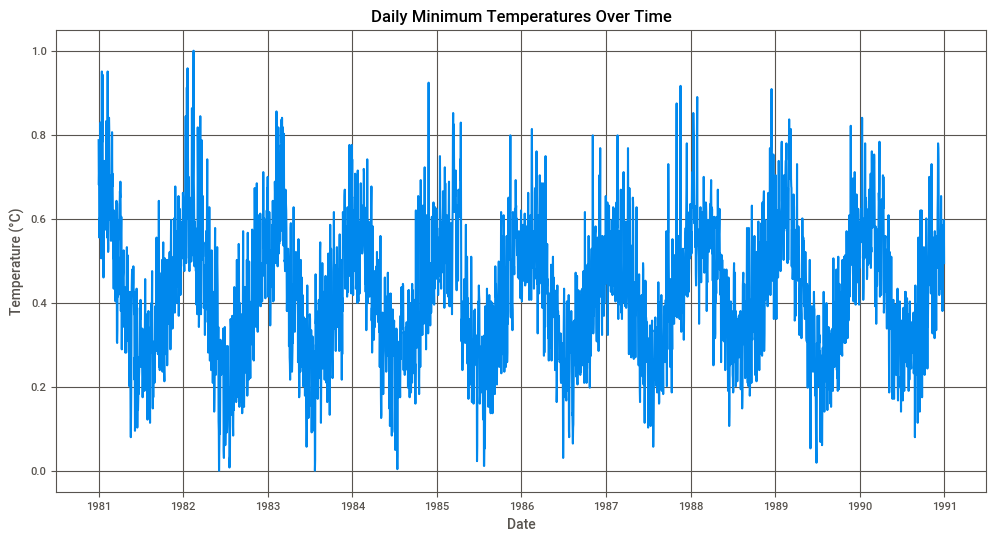

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temp'])
plt.title('Daily Minimum Temperatures Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


Seasonal Decomposition of Temperature Data and Seasonal Trends

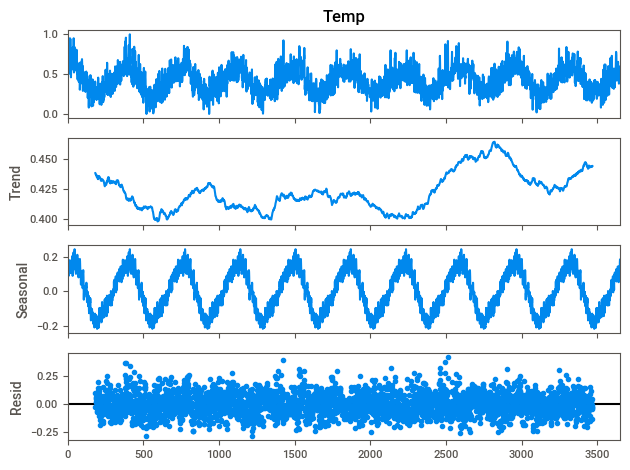

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Temp'], model='additive', period=365)
result.plot()
plt.show()


Visualize Predictions for MLP Model

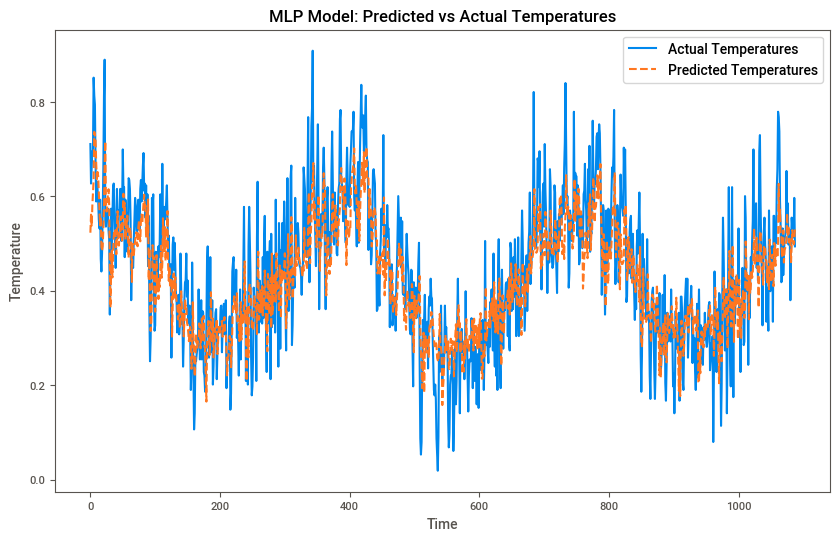

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test_label, label='Actual Temperatures')
plt.plot(mlp_predictions, label='Predicted Temperatures', linestyle='--')
plt.title('MLP Model: Predicted vs Actual Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Visualize Predictions for RNN Model

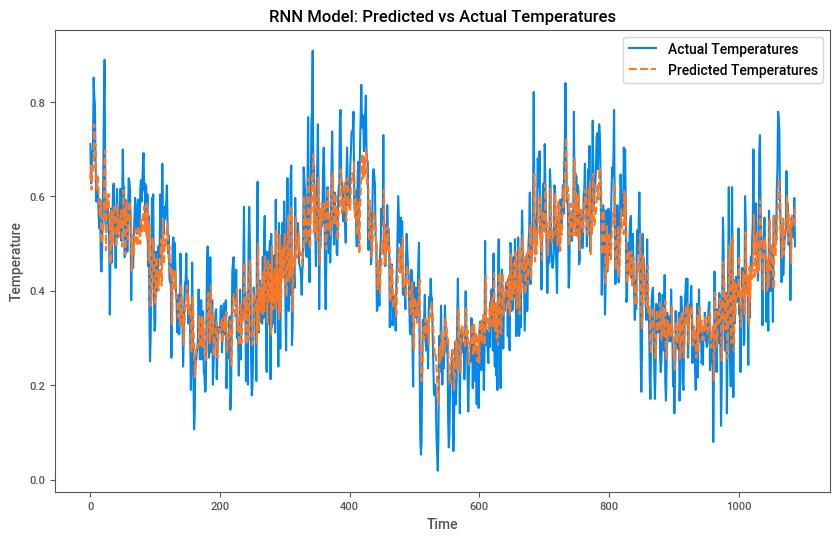

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(test_label, label='Actual Temperatures')
plt.plot(rnn_predictions, label='Predicted Temperatures', linestyle='--')
plt.title('RNN Model: Predicted vs Actual Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


Need to write about, architecture RNN and write about why rnn performed better than mlp as per your knowledge.


#Architecture.

# Here we have use 3 layers

# Input Layer is used to take the data layer.

# The input data needs to be shaped as [samples, time steps, features] for an LSTM model.
# For a univariate time series, there would be a single feature - the value at each time step.

#Multiple LSTM layers allow learning higher-level temporal abstractions and dependencies.
#Common to have 2-3 LSTM layers with dropout between them.
#Number of memory units in LSTM layers is a key hyperparameter governing model capacity.

# The output shape should match the prediction target. For univariate forecasting this is usually a single unit.
# Can activate with a linear activation since it's regression. Other options could be softmax for classification.


#Results

# RNN model performed better than the MLP model as we can see from the results. the lower the loss value the better the function.

#MLP Model - MAE: 0.07494115616399873
#MLP Model - RMSE: 0.09463825455749447

#RNN Model - MAE: 0.06910899406415853
#RNN Model - RMSE: 0.08700322850940238

#Here we are finding  the next 10 years forecasting data

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Temp']])

time_steps = 30
sequences = []
labels = []
for i in range(len(scaled_data) - time_steps):
    sequences.append(scaled_data[i : i + time_steps])
    labels.append(scaled_data[i + time_steps])

X = np.array(sequences)
y = np.array(labels)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)

forecast_days = 365 * 10  # Total forecast days
batch_size = 30  # Number of days to forecast per iteration

forecast = []

for i in range(0, forecast_days, batch_size):
    input_sequences = np.array([scaled_data[-time_steps:]])


    for _ in range(batch_size):
        prediction = model.predict(input_sequences)
        forecast.append(prediction[0, 0])
        input_sequences = np.append(input_sequences[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the forecasted values to get actual temperature values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Show the forecast
print("Forecasted Temperatures for Next 10 Years:")
print(forecast)


Epoch 1/10
91/91 [==============================] - 7s 31ms/step - loss: 0.0182
Epoch 2/10
91/91 [==============================] - 4s 44ms/step - loss: 0.0116
Epoch 3/10
91/91 [==============================] - 3s 30ms/step - loss: 0.0115
Epoch 4/10
91/91 [==============================] - 3s 31ms/step - loss: 0.0116
Epoch 5/10
91/91 [==============================] - 3s 33ms/step - loss: 0.0112
Epoch 6/10
91/91 [==============================] - 4s 41ms/step - loss: 0.0111
Epoch 7/10
91/91 [==============================] - 3s 33ms/step - loss: 0.0110
Epoch 8/10
91/91 [==============================] - 3s 32ms/step - loss: 0.0106
Epoch 9/10
91/91 [==============================] - 3s 32ms/step - loss: 0.0096
Epoch 10/10
1/1 [==============================] - 0s 25ms/step
Forecasted Temperatures for Next 10 Years:
[[12.6086  ]
 [12.575884]
 [12.484412]
 ...
 [10.782863]
 [10.725977]
 [10.667617]]
